In [1]:

from simulator.reporters import TransitionReporter
from simulator.reporters.utilization_reporter import UtilizationReporter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from simulator import Config

In [2]:
def getTupleTemplate(batchId: str):
    reportMap = None
    with open(
        "results/reportMaps/reportMap{id}.json".format(id = batchId),
        "r") as reportFile:
        reportMap = json.load(reportFile)
    
    # Finding all config changes
    configList = set()
    for report in reportMap:
        varients = report["varient"]
        for varient in varients:
            configList.add(varient["config"])
            
    tupleTemplate = {}
    for config in configList:
        tupleTemplate[config] = Config.get(config)
        tupleTemplate[config + "_default"] = True
    return tupleTemplate  

def loadDataframe(batchId: str) -> pd.DataFrame:
    reportMap = None
    with open(
        "results/reportMaps/reportMap{id}.json".format(id = batchId),
        "r") as reportFile:
        reportMap = json.load(reportFile)

    tupleTemplate = getTupleTemplate(batchId)
    tupleList = []
    for report in reportMap:
        reportTupleTemplate = tupleTemplate.copy()
        runId = report["runId"]
        varients = report["varient"]
        for varient in varients:
            config = varient["config"]
            reportTupleTemplate[config] = varient["value"]
            reportTupleTemplate[config + "_default"] = False
        reportTupleTemplate["run_id"] = runId
        
        mobileReport = TransitionReporter.getListFromPickle("results/report/{batchId}/reportmobile{runId}.pkl".format(batchId = batchId, runId = runId))
        for item in mobileReport:
            tuple = reportTupleTemplate.copy()
            tuple["task_id"] = item.task.id()
            tuple["arrival_time"] = item.task.arrivalTime()
            tuple["delay"] = item.delay
            tuple["power"] = item.powerConsumtion
            tuple["reward"] = item.reward
            tuple["action"] = item.action
            tuple["hopLimit"] = item.task.hopLimit()
            tupleList.append(tuple)
            
    df = pd.DataFrame(tupleList)
    # unify action values
    df["action"] = df["action"].apply(lambda x: 0 if ("0" in str(x)) else (1 if ("1" in str(x)) else x))
    
    return df

def loadUtilDataframe(batchId: str) -> pd.DataFrame:
    reportMap = None
    with open(
        "results/reportMaps/reportMap{id}.json".format(id = batchId),
        "r") as reportFile:
        reportMap = json.load(reportFile)

    tupleTemplate = getTupleTemplate(batchId)
    tupleList = []
    for report in reportMap:
        reportTupleTemplate = tupleTemplate.copy()
        runId = report["runId"]
        varients = report["varient"]
        for varient in varients:
            config = varient["config"]
            reportTupleTemplate[config] = varient["value"]
            reportTupleTemplate[config + "_default"] = False
        reportTupleTemplate["run_id"] = runId
        
        utilMobileReport = UtilizationReporter.getListFromPickle("results/report/{batchId}/reportmobile-util-{runId}.pkl".format(batchId = batchId, runId = runId))
        
        for item in utilMobileReport:
            tuple = reportTupleTemplate.copy()
            tuple["task_id"] = item.task.id()
            tuple["environment"] = "mobile"
            tuple["run_time"] = item.runTime
            tuple["run_start"] = item.runStart
            tupleList.append(tuple)
        
        utilEdgeReport = UtilizationReporter.getListFromPickle("results/report/{batchId}/reportedge-util-{runId}.pkl".format(batchId = batchId, runId = runId))
        for item in utilEdgeReport:
            tuple = reportTupleTemplate.copy()
            tuple["task_id"] = item.task.id()
            tuple["environment"] = "edge"
            tuple["run_time"] = item.runTime
            tuple["run_start"] = item.runStart
            tupleList.append(tuple)   
        
    df = pd.DataFrame(tupleList)
    
    return df

In [13]:
batchId = "V7"
dfTrans = loadDataframe(batchId)
dfUtil = loadUtilDataframe(batchId)

In [14]:
line_props = {
    "DQL-edge (centered)": ("C9", "-."),
    "DQL-edge": ("C9", "-"),
    "DQL-local (centered)": ("C5", "-."),
    "DQL-local": ("C5", "-"),
    "Reinforce-edge (centered)": ("C6", "-."),
    "Reinforce-edge": ("C6", "-"),
    "Reinforce-local (centered)": ("C7", "-."),
    "Reinforce-local": ("C7", "-"),
    "greedy (centered)": ("C1", "-."),
    "greedy": ("C1", "-"),
    "random (centered)": ("C2", "-."),
    "random": ("C2", "-"),
    "remote (centered)": ("C3", "-."),
    "remote": ("C3", "-"),
    "local": ("C4", "-")
}

In [36]:
df = dfTrans
variable_conditions_method = {
    "DQL-edgeUniform": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "DQL-edgeCentered": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & 
    (df["boxworld_centered_mobile_nodes"] == True),

    "DQL-localUniform": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "DQL-localCentered": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & 
    (df["boxworld_centered_mobile_nodes"] == True),

    "Reinforce-edgeUniform": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "Reinforce-edgeCentered": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote") & 
    (df["boxworld_centered_mobile_nodes"] == True),

    "Reinforce-localUniform": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "Reinforce-localCentered": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local") & 
    (df["boxworld_centered_mobile_nodes"] == True),


    "GreedyUniform": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "GreedyCentered": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & 
    (df["boxworld_centered_mobile_nodes"] == True),


    "randomUniform": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "randomCentered": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & 
    (df["boxworld_centered_mobile_nodes"] == True),


    "remoteUniform": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & 
    (df["boxworld_centered_mobile_nodes"] == False),

    "remoteCentered": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & 
    (df["boxworld_centered_mobile_nodes"] == True),


    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local"),
}
variable_conditions_class = {
    "lambda = 0.50, count = 100": (df["task_generator_lambda"] == 0.5) & (df["boxworld_mobile_nodes"] == 100),
    "lambda = 0.50, count = 75": (df["task_generator_lambda"] == 0.5) & (df["boxworld_mobile_nodes"] == 75),
    "lambda = 0.50, count = 50": (df["task_generator_lambda"] == 0.5) & (df["boxworld_mobile_nodes"] == 50),
    "lambda = 0.50, count = 25": (df["task_generator_lambda"] == 0.5) & (df["boxworld_mobile_nodes"] == 25),
    "lambda = 0.25, count = 50": (df["task_generator_lambda"] == 0.25) & (df["boxworld_mobile_nodes"] == 50),
    "lambda = 0.75, count = 50": (df["task_generator_lambda"] == 0.75) & (df["boxworld_mobile_nodes"] == 50),
    "lambda = 1.00, count = 50": (df["task_generator_lambda"] == 1) & (df["boxworld_mobile_nodes"] == 50)
}
results = []
results.append([""] + list(variable_conditions_class.keys()))
fig, ax = plt.subplots(figsize=(1, 0.3))
ax.axis('off')
for key_method, value_method in variable_conditions_method.items():
    item_condition = value_method
    result = [key_method]
    for key_class, value_class in variable_conditions_class.items():
        #Mean:
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        std = df.loc[class_condition, ["reward"]].std()
        result.append("\\(\\mu = {:.2f}".format(data["reward"]) + ", \  \\sigma = {:.2f}\\)".format(std["reward"]))
        #Trend:
        data = -df.loc[class_condition, ["reward"]].groupby(
            pd.cut(df["arrival_time"], np.arange(0, 500, 10))).mean()
        data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
        plt.cla()
        ax.axis('off')
        ax.plot(data)
        plt.savefig('plots/trends/{method_var}_{class_var}.eps'.format(method_var = key_method, class_var = key_class).replace(' ', '').replace(',', '').replace('=', '')
        , bbox_inches='tight', pad_inches=0.0, format='eps') 
    results.append(result)
results
pd.DataFrame(results)

,0,1,2,3,4,5,6,7
0,,"lambda = 0.50, count = 100","lambda = 0.50, count = 75","lambda = 0.50, count = 50","lambda = 0.50, count = 25","lambda = 0.25, count = 50","lambda = 0.75, count = 50","lambda = 1.00, count = 50"
1,DQL-edgeUniform,"\(\mu = 6.26, \ \sigma = 3.26\)","\(\mu = 2.99, \ \sigma = 1.93\)","\(\mu = 2.54, \ \sigma = 1.84\)","\(\mu = 2.39, \ \sigma = 1.80\)","\(\mu = 1.99, \ \sigma = 1.56\)","\(\mu = 3.52, \ \sigma = 2.31\)","\(\mu = 7.27, \ \sigma = 2.87\)"
2,DQL-edgeCentered,"\(\mu = 6.05, \ \sigma = 2.30\)","\(\mu = 4.15, \ \sigma = 2.53\)","\(\mu = 2.87, \ \sigma = 1.85\)","\(\mu = 2.69, \ \sigma = 1.82\)","\(\mu = 2.19, \ \sigma = 1.51\)","\(\mu = 4.75, \ \sigma = 2.52\)","\(\mu = 9.61, \ \sigma = 5.47\)"
3,DQL-localUniform,"\(\mu = 6.04, \ \sigma = 4.29\)","\(\mu = 4.47, \ \sigma = 4.38\)","\(\mu = 3.78, \ \sigma = 4.08\)","\(\mu = 4.36, \ \sigma = 6.27\)","\(\mu = 3.15, \ \sigma = 2.57\)","\(\mu = 6.04, \ \sigma = 8.85\)","\(\mu = 15.87, \ \sigma = 17.41\)"
4,DQL-localCentered,"\(\mu = 10.40, \ \sigma = 7.94\)","\(\mu = 5.24, \ \sigma = 4.80\)","\(\mu = 4.72, \ \sigma = 5.61\)","\(\mu = 5.00, \ \sigma = 7.17\)","\(\mu = 3.25, \ \sigma = 2.46\)","\(\mu = 9.48, \ \sigma = 8.65\)","\(\mu = 22.67, \ \sigma = 17.89\)"
5,Reinforce-edgeUniform,"\(\mu = 5.21, \ \sigma = 3.46\)","\(\mu = 4.96, \ \sigma = 3.63\)","\(\mu = 4.96, \ \sigma = 3.76\)","\(\mu = 4.58, \ \sigma = 3.29\)","\(\mu = 3.99, \ \sigma = 2.57\)","\(\mu = 8.00, \ \sigma = 7.70\)","\(\mu = 32.80, \ \sigma = 38.25\)"
6,Reinforce-edgeCentered,"\(\mu = 14.10, \ \sigma = 13.17\)","\(\mu = 4.95, \ \sigma = 3.05\)","\(\mu = 4.63, \ \sigma = 3.19\)","\(\mu = 4.78, \ \sigma = 3.54\)","\(\mu = 3.96, \ \sigma = 2.47\)","\(\mu = 6.28, \ \sigma = 4.90\)","\(\mu = 32.64, \ \sigma = 22.59\)"
7,Reinforce-localUniform,"\(\mu = 4.81, \ \sigma = 3.36\)","\(\mu = 4.73, \ \sigma = 3.52\)","\(\mu = 4.74, \ \sigma = 3.43\)","\(\mu = 4.73, \ \sigma = 3.46\)","\(\mu = 3.92, \ \sigma = 2.58\)","\(\mu = 7.39, \ \sigma = 7.73\)","\(\mu = 29.94, \ \sigma = 47.68\)"
8,Reinforce-localCentered,"\(\mu = 6.25, \ \sigma = 4.42\)","\(\mu = 5.19, \ \sigma = 3.52\)","\(\mu = 4.73, \ \sigma = 3.26\)","\(\mu = 4.87, \ \sigma = 3.61\)","\(\mu = 3.93, \ \sigma = 2.48\)","\(\mu = 9.00, \ \sigma = 11.16\)","\(\mu = 42.16, \ \sigma = 62.29\)"
9,GreedyUniform,"\(\mu = 6.86, \ \sigma = 4.40\)","\(\mu = 4.41, \ \sigma = 2.42\)","\(\mu = 3.07, \ \sigma = 1.91\)","\(\mu = 2.22, \ \sigma = 1.54\)","\(\mu = 1.77, \ \sigma = 1.17\)","\(\mu = 4.64, \ \sigma = 2.56\)","\(\mu = 11.08, \ \sigma = 8.07\)"


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


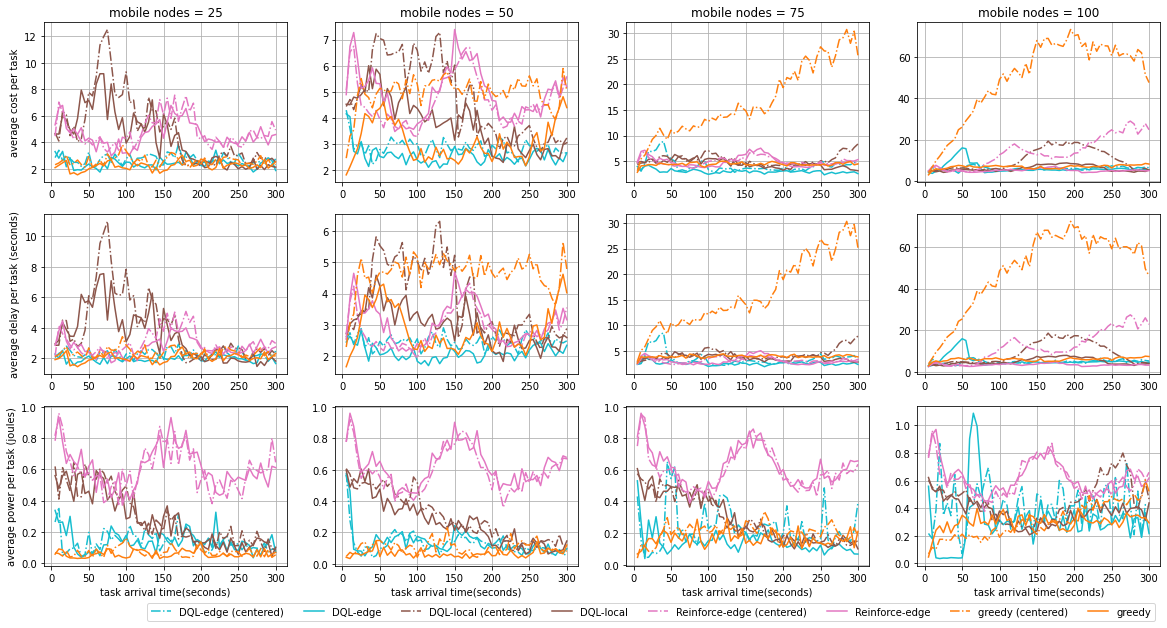

In [30]:
df = dfTrans
vairable_conditions = {
    "DQL-edge (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-edge": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local (centered)": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "Reinforce-edge (centered)": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "Reinforce-edge": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    #"Reinforce-local (centered)": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local") & (df["boxworld_centered_mobile_nodes"] == True),
    #"Reinforce-local": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False)
}
varients = [
    [(25, 0.5, 'reward', 'cost', True, ''),
    (50, 0.5, 'reward', 'cost', True, ''),
    (75, 0.5, 'reward', 'cost', True, ''),
    (100, 0.5, 'reward', 'cost', True, '')],
    [(25, 0.5, 'delay', 'delay', False, ' (seconds)'),
    (50, 0.5, 'delay', 'delay', False, ' (seconds)'),
    (75, 0.5, 'delay', 'delay', False, ' (seconds)'),
    (100, 0.5, 'delay', 'delay', False, ' (seconds)')],
    [(25, 0.5, 'power', 'power', False, ' (joules)'),
    (50, 0.5, 'power', 'power', False, ' (joules)'),
    (75, 0.5, 'power', 'power', False, ' (joules)'),
    (100, 0.5, 'power', 'power', False, ' (joules)')]
]
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
for x in range(0, 3):
    for y in range(0, 4):
        varient = varients[x][y]
        ax = axs[x, y]
        graphs = {}
        for key, value in vairable_conditions.items():
            item_condition = (df["boxworld_mobile_nodes"] == varient[0]) & (df["task_generator_lambda"] == varient[1]) & value
            data = (-1 if varient[4] else 1) * df.loc[item_condition, [varient[2]]].groupby(
                pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
            data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
            graphs[key] = data

        for key, data in graphs.items():
            ax.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

        if y == 0:
            ax.set(ylabel = 'average {method} per task{unit}'.format(method = varient[3], unit = varient[5]))
        if x == 2:
            ax.set(xlabel = 'task arrival time(seconds)')
        if x == 0:
            ax.set_title("mobile nodes = {count}".format(count = varient[0]))
        ax.grid('on')

plt.legend(bbox_to_anchor=(1, -.2), ncol=len(df.columns))
plt.savefig('plots/two_methods.eps', bbox_inches='tight', format='eps')
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


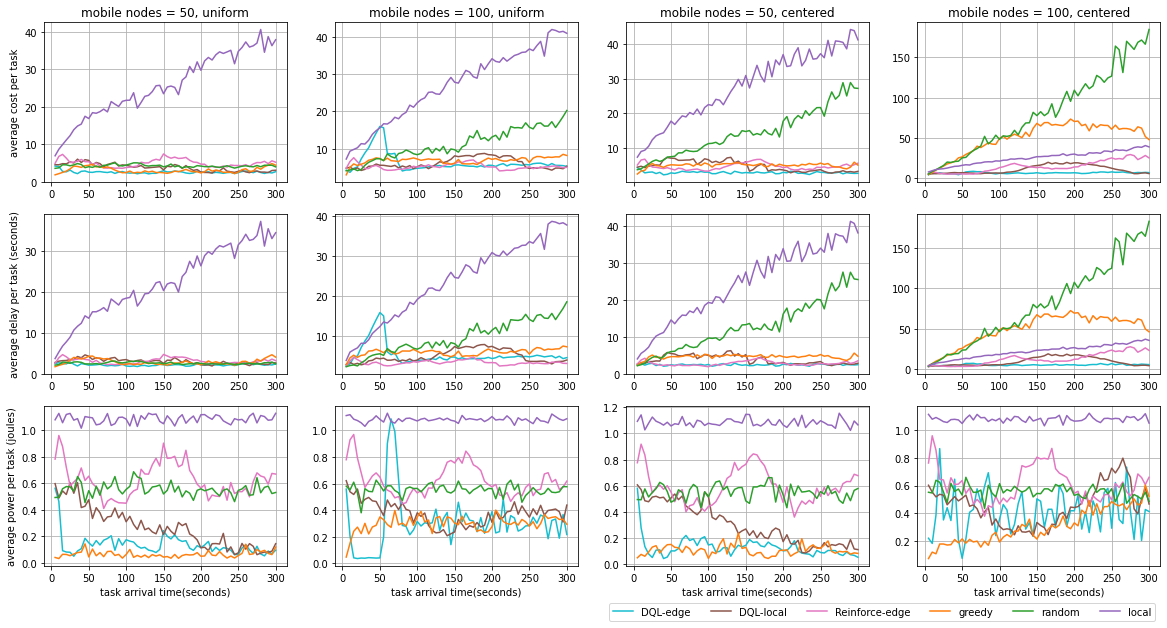

In [31]:
df = dfTrans
vairable_conditions = {
    "DQL-edge": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote"),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local"),
    "Reinforce-edge": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote"),
    #"Reinforce-local": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local"),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy"),
    "random": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local"),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local")
}
varients = [
    [(50, 0.5, 'reward', 'cost', True, '', False),
    (100, 0.5, 'reward', 'cost', True, '', False),
    (50, 0.5, 'reward', 'cost', True, '', True),
    (100, 0.5, 'reward', 'cost', True, '', True),],
    [(50, 0.5, 'delay', 'delay', False, ' (seconds)', False),
    (100, 0.5, 'delay', 'delay', False, ' (seconds)', False),
    (50, 0.5, 'delay', 'delay', False, ' (seconds)', True),
    (100, 0.5, 'delay', 'delay', False, ' (seconds)', True),],
    [(50, 0.5, 'power', 'power', False, ' (joules)', False),
    (100, 0.5, 'power', 'power', False, ' (joules)', False),
    (50, 0.5, 'power', 'power', False, ' (joules)', True),
    (100, 0.5, 'power', 'power', False, ' (joules)', True),]
]
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
for x in range(0, 3):
    for y in range(0, 4):
        varient = varients[x][y]
        ax = axs[x, y]
        graphs = {}
        for key, value in vairable_conditions.items():
            item_condition = ((df["boxworld_mobile_nodes"] == varient[0]) & (df["task_generator_lambda"] == varient[1]) &
                            (df["boxworld_centered_mobile_nodes"] == varient[6]) & value)
            data = (-1 if varient[4] else 1) * df.loc[item_condition, [varient[2]]].groupby(
                pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
            data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
            graphs[key] = data
        
        for key, data in graphs.items():
            ax.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

        if y == 0:
            ax.set(ylabel = 'average {method} per task{unit}'.format(method = varient[3], unit = varient[5]))
        if x == 2:
            ax.set(xlabel = 'task arrival time(seconds)')
        if x == 0:
            ax.set_title("mobile nodes = {count}, {position}".format(
                position = "centered" if varient[6] else "uniform", count = varient[0]))
        ax.grid('on')

plt.legend(bbox_to_anchor=(1, -.2), ncol=len(df.columns))
plt.savefig('plots/all_methods.eps', bbox_inches='tight', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


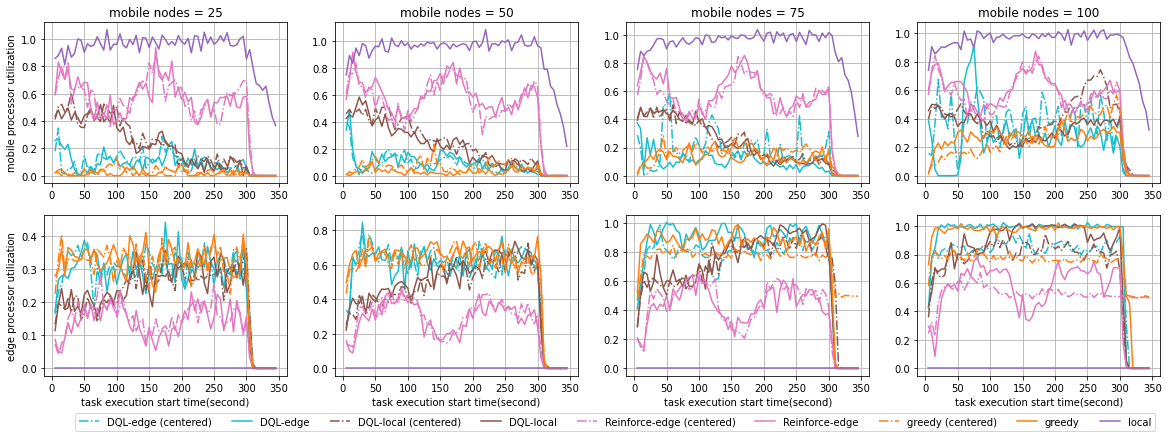

In [33]:
df = dfUtil
vairable_conditions = {
    "DQL-edge (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-edge": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local (centered)": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "Reinforce-edge (centered)": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "Reinforce-edge": (df["mobile_selector"] == "reinforce_remote") & (df["edge_selector"] == "reinforce_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    #"Reinforce-local (centered)": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local") & (df["boxworld_centered_mobile_nodes"] == True),
    #"Reinforce-local": (df["mobile_selector"] == "reinforce_local") & (df["edge_selector"] == "reinforce_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
varients = [
    #(mobileNodes, arrivalRate, processorsCount, environment)
    [(25, 0.5, 25, "mobile"),
    (50, 0.5, 50, "mobile"),
    (75, 0.5, 75, "mobile"),
    (100, 0.5, 100, "mobile")],
    [(25, 0.5, 16, "edge"),
    (50, 0.5, 16, "edge"),
    (75, 0.5, 16, "edge"),
    (100, 0.5, 16, "edge")],
]
fig, axs = plt.subplots(2, 4, figsize=(20, 6.5))
for x in range(0, 2):
    for y in range(0, 4):
        varient = varients[x][y]
        ax = axs[x, y]
        graphs = {}
        for key, value in vairable_conditions.items():
            item_condition = ((df["boxworld_mobile_nodes"] == varient[0]) & (df["task_generator_lambda"] == varient[1]) &
                             (df["environment"] == varient[3]) & value)
            data = df.loc[item_condition, ["run_time"]].groupby(
                pd.cut(df["run_start"], np.arange(0, 350, 5))).sum() / (varient[2] * 5)
            data.index = pd.IntervalIndex(data.index.get_level_values('run_start')).right
            graphs[key] = data

        for key, data in graphs.items():
            ax.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

        if y == 0:
            ax.set(ylabel = '{node} processor utilization'.format(node = varient[3]))
        if x == 1:
            ax.set(xlabel = 'task execution start time(second)')
        if x == 0:
            ax.set_title("mobile nodes = {count}".format(count = varient[0]))
        ax.grid('on')

plt.legend(bbox_to_anchor=(1, -.2), ncol=len(df.columns))
plt.savefig('plots/methods_utilization.eps', bbox_inches='tight', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


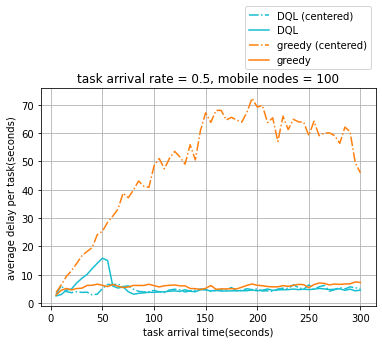

In [8]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["delay"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average delay per task(seconds)')
plt.xlabel('task arrival time(seconds)')
lgd = plt.legend(bbox_to_anchor=(1, 1.4))
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.grid('on')
plt.savefig('plots/delay_two_methods_100.eps', bbox_inches='tight', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


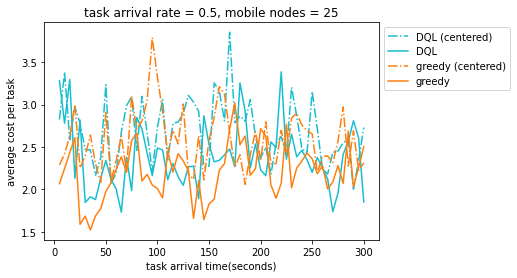

In [9]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 25) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("task arrival rate = 0.5, mobile nodes = 25")
plt.savefig('plots/cost_two_methods_25.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


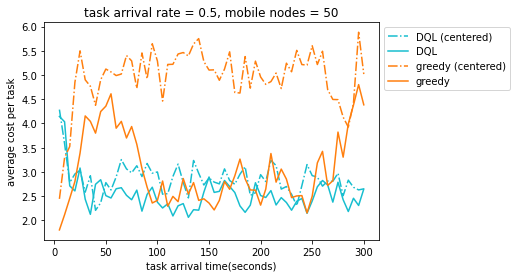

In [10]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 50) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("task arrival rate = 0.5, mobile nodes = 50")
plt.savefig('plots/cost_two_methods_50.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


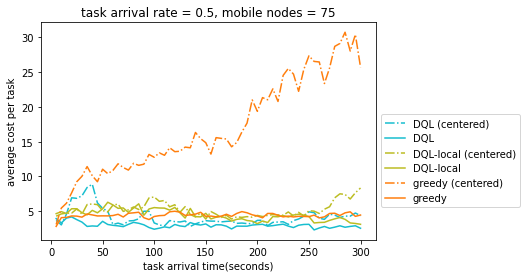

In [11]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local (centered)": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 75) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend(bbox_to_anchor=(1, 0.6))
plt.title("task arrival rate = 0.5, mobile nodes = 75")
plt.savefig('plots/cost_two_methods_75.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


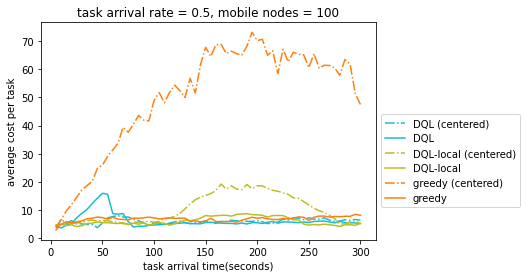

In [12]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local (centered)": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend(bbox_to_anchor=(1, 0.6))
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.savefig('plots/cost_two_methods_100.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


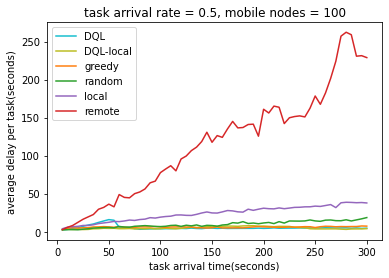

In [13]:
vairable_conditions = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "remote": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["delay"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average delay per task(seconds)')
plt.xlabel('task arrival time(seconds)')
plt.legend()
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.savefig('plots/delay_all_methods_uniform.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


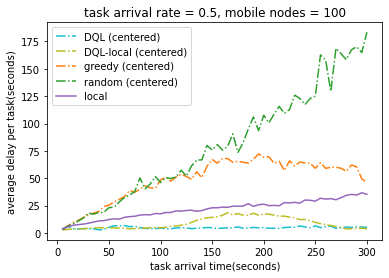

In [14]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local (centered)": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random (centered)": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["delay"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average delay per task(seconds)')
plt.xlabel('task arrival time(seconds)')
plt.legend()
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.savefig('plots/delay_all_methods_centered.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


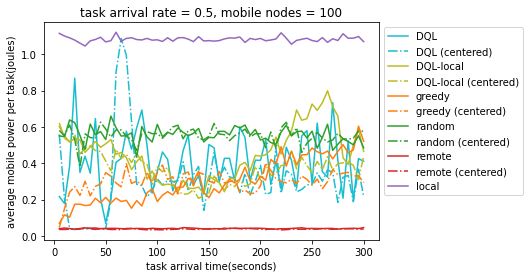

In [15]:
vairable_conditions = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local (centered)": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "random (centered)": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "remote": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "remote (centered)": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local")
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = df.loc[item_condition, ["power"]].groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average mobile power per task(joules)')
plt.xlabel('task arrival time(seconds)')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.savefig('plots/power_all_methods.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


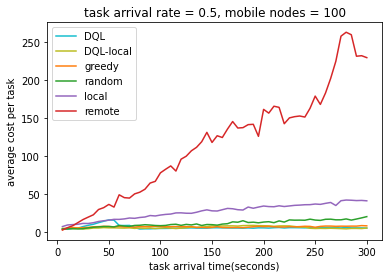

In [16]:
vairable_conditions = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "remote": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend()
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.savefig('plots/cost_all_methods_uniform.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


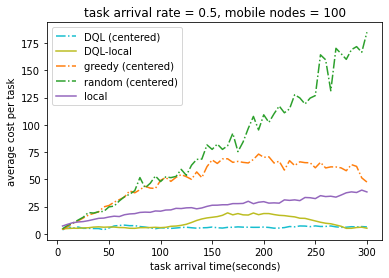

In [17]:
vairable_conditions = {
    "DQL (centered)": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "DQL-local": (df["mobile_selector"] == "dql_local") & (df["edge_selector"] == "dql_local") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy (centered)": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random (centered)": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
condition =  (df["boxworld_mobile_nodes"] == 100) & (df["task_generator_lambda"] == 0.5)
graphs = {}
for key, value in vairable_conditions.items():
    item_condition = condition & value
    data = (-df.loc[item_condition, ["reward"]]).groupby(
        pd.cut(df["arrival_time"], np.arange(0, 500, 5))).mean()
    data.index = pd.IntervalIndex(data.index.get_level_values('arrival_time')).right
    graphs[key] = data

for key, data in graphs.items():
    plt.plot(data, label=key, c = line_props[key][0], ls=line_props[key][1])

plt.ylabel('average cost per task')
plt.xlabel('task arrival time(seconds)')
plt.legend()
plt.title("task arrival rate = 0.5, mobile nodes = 100")
plt.savefig('plots/cost_all_methods_centered.eps', format='eps')

In [18]:
def barchartPlotter(values, valueLabels, classesLabel, yLabel, xLabel = None, legenLoc = None, savePath = None):
  labels = classesLabel
  x = np.arange(len(labels))  # the label locations
  width = 0.2  # the width of the bars
  fig, ax = plt.subplots()
  rects = []
  for i in range(0, len(values)):
    rects.append(ax.bar(x + (i - (len(values) - 1) / 2 ) * width, values[i], width, label=valueLabels[i]))
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(yLabel)
  ax.set_xlabel(xLabel)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  if legenLoc is None:  
    ax.legend()
  else:
    ax.legend(loc=legenLoc)
  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')
  #for i in range(0, len(values)):
  #  autolabel(rects[i])
  fig.tight_layout()
  
  if not (savePath is None):
    plt.savefig(savePath + '.eps', format='eps')
  plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


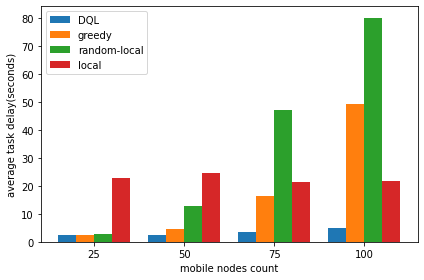

In [19]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["delay"]].mean()
        result.append(data["delay"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average task delay(seconds)", xLabel = "mobile nodes count", savePath = "plots/mobile_node_counts_delay")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


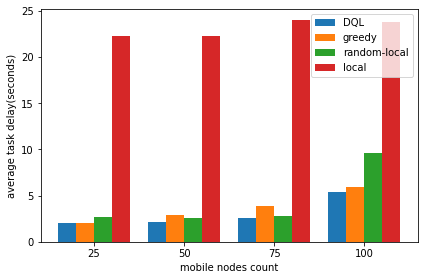

In [20]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["delay"]].mean()
        result.append(data["delay"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average task delay(seconds)", xLabel = "mobile nodes count", savePath = "plots/mobile_node_counts_delay")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


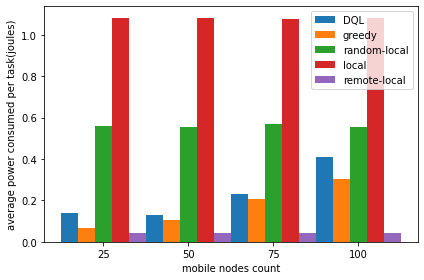

In [21]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "remote-local": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["power"]].mean()
        result.append(data["power"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average power consumed per task(joules)", xLabel = "mobile nodes count",
                 savePath = "plots/mobile_node_counts_power", legenLoc="upper right")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


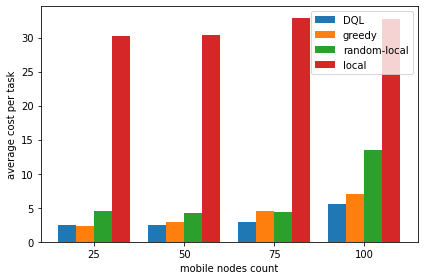

In [22]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        result.append(data["reward"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average cost per task", xLabel = "mobile nodes count", savePath = "plots/mobile_node_counts_reward")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


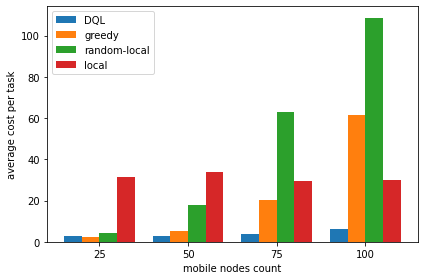

In [23]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
variable_conditions_class = {
    "25": (df["boxworld_mobile_nodes"] == 25),
    "50": (df["boxworld_mobile_nodes"] == 50),
    "75": (df["boxworld_mobile_nodes"] == 75),
    "100": (df["boxworld_mobile_nodes"] == 100)
}

condition = (df["task_generator_lambda"] == 0.5) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        result.append(data["reward"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average cost per task", xLabel = "mobile nodes count", savePath = "plots/mobile_node_counts_reward")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


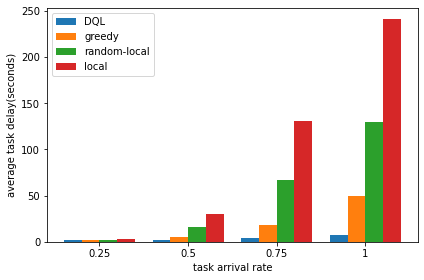

In [24]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["delay"]].mean()
        result.append(data["delay"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average task delay(seconds)", xLabel = "task arrival rate", savePath = "plots/data_rate_delay")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


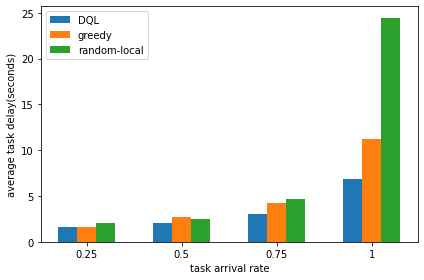

In [25]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["delay"]].mean()
        result.append(data["delay"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average task delay(seconds)", xLabel = "task arrival rate", savePath = "plots/data_rate_delay")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


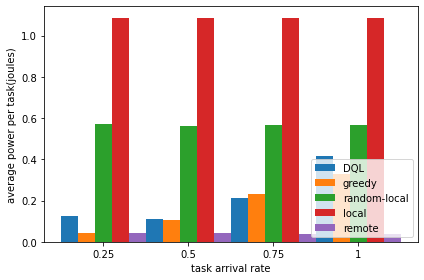

In [26]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "remote": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["power"]].mean()
        result.append(data["power"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average power per task(joules)", xLabel = "task arrival rate", savePath = "plots/data_rate_power", legenLoc="lower right")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


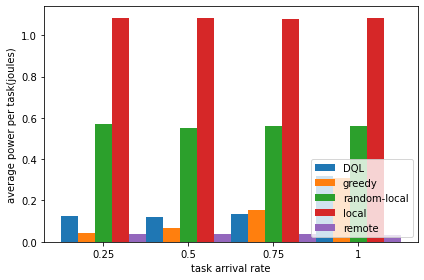

In [27]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False),
    "remote": (df["mobile_selector"] == "remote") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50) & (df["arrival_time"] >= 100)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = df.loc[class_condition, ["power"]].mean()
        result.append(data["power"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average power per task(joules)", xLabel = "task arrival rate", savePath = "plots/data_rate_power", legenLoc="lower right")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


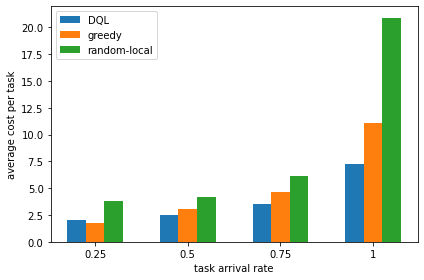

In [28]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == False),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == False),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == False)
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        result.append(data["reward"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average cost per task", xLabel = "task arrival rate", savePath = "plots/data_rate_reward", legenLoc="upper left")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


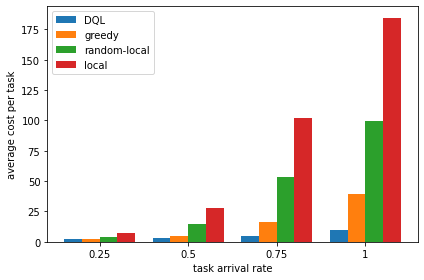

In [29]:
variable_conditions_method = {
    "DQL": (df["mobile_selector"] == "dql_remote") & (df["edge_selector"] == "dql_remote") & (df["boxworld_centered_mobile_nodes"] == True),
    "greedy": (df["mobile_selector"] == "greedy") & (df["edge_selector"] == "greedy") & (df["boxworld_centered_mobile_nodes"] == True),
    "random-local": (df["mobile_selector"] == "random") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True),
    "local": (df["mobile_selector"] == "local") & (df["edge_selector"] == "local") & (df["boxworld_centered_mobile_nodes"] == True)
}
variable_conditions_class = {
    "0.25": (df["task_generator_lambda"] == 0.25),
    "0.5": (df["task_generator_lambda"] == 0.5),
    "0.75": (df["task_generator_lambda"] == 0.75),
    "1": (df["task_generator_lambda"] == 1)
}

condition = (df["boxworld_mobile_nodes"] == 50)
results = []
for key_method, value_method in variable_conditions_method.items():
    item_condition = condition & value_method
    result = []
    for key_class, value_class in variable_conditions_class.items():
        class_condition = item_condition & value_class
        data = -df.loc[class_condition, ["reward"]].mean()
        result.append(data["reward"])
    results.append(result)


barchartPlotter(results, list(variable_conditions_method.keys()), list(variable_conditions_class.keys()),
                "average cost per task", xLabel = "task arrival rate", savePath = "plots/data_rate_reward", legenLoc="upper left")